<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Larissa_Santesso/entrega_final/run00_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive in Colab backend

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Experiment Configuration

In [ ]:
# Configuration of the experiment of this notebook (used in variables along code and config of W&B)
config_exp={
        "learning_rate": 1e-5,
        "batch_size": 20,
        "architecture": "Vit_768dm_T5_base_768dm",
        "dataset": "MS-COCO Complete",
        "epochs": 40,
        "eval_epochs": 5,
        "max_seq_length": 32,
        "encoder_pretrained_model": "google/vit-base-patch16-224-in21k",
        "decoder_pretrained_model": "t5-base",
        "path_save_model":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/modelos/model_exp008_run02.pt",
        "path_save_checkpoints":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/checkpoints/",
        "checkpoint_folder_name": "checkpoint_exp008.tar"

}

# Installing and importing libraries


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 31.6 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 12.4 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 26.4 MB/s 
     |████████████████████████████████| 1.1 MB 42.8 MB/s 
     |████████████████████████████████| 140 kB 75.6 MB/s 
     |████████████████████████████████| 212 kB 74.9 MB/s 
     |████████████████████████████████| 127 kB 66.9 MB/s 
     |████████████████████████████████| 271 kB 61.8 MB/s 
     |████████████████████████████████| 144 kB 50.3 MB/s 
     |████████████████████████████████| 94 kB 1.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 7.6 MB/s 


In [ ]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pycocoevalcap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104.3 MB 69 kB/s 


In [ ]:
from transformers import ViTFeatureExtractor, ViTModel, ViTConfig
from transformers import T5ForConditionalGeneration, T5Tokenizer
import datasets

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

from matplotlib import pyplot as plt
from typing import Any, Callable, Optional, Tuple, List
import math
import random
import numpy as np
import json
from PIL import Image
import os
import time

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader

import collections
import itertools
import functools
from tqdm.notebook import tqdm

bleu = datasets.load_metric('sacrebleu')

feature_extractor = ViTFeatureExtractor.from_pretrained(config_exp["encoder_pretrained_model"])

tokenizer = T5Tokenizer.from_pretrained(config_exp["decoder_pretrained_model"])

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


# Setting Seed and Device

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [ ]:
# Check which GPU we are using
!nvidia-smi

Tue Jul 12 14:37:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Dataset MS-COCO 2014

Downloaded .zip files (below) from <https://cocodataset.org/#download> and moved them to a personal folder in Google Drive. 

*   2014 Train images [83K/13GB]
*   2014 Val images [41K/6GB]
*   2014 Train/Val annotations [241MB]



In [ ]:
!unzip -o /content/gdrive/MyDrive/Colab\ Notebooks/Projeto/dataset/annotations_trainval2014.zip -d /content/

Archive:  /content/gdrive/MyDrive/Colab Notebooks/Projeto/dataset/annotations_trainval2014.zip
  inflating: /content/annotations/instances_train2014.json  
  inflating: /content/annotations/instances_val2014.json  
  inflating: /content/annotations/person_keypoints_train2014.json  
  inflating: /content/annotations/person_keypoints_val2014.json  
  inflating: /content/annotations/captions_train2014.json  
  inflating: /content/annotations/captions_val2014.json  


In [ ]:
!unzip -o /content/gdrive/MyDrive/Colab\ Notebooks/Projeto/dataset/train2014.zip -d /content/

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: /content/train2014/COCO_train2014_000000408557.jpg  
 extracting: /content/train2014/COCO_train2014_000000013714.jpg  
 extracting: /content/train2014/COCO_train2014_000000194043.jpg  
 extracting: /content/train2014/COCO_train2014_000000219859.jpg  
 extracting: /content/train2014/COCO_train2014_000000278135.jpg  
 extracting: /content/train2014/COCO_train2014_000000141015.jpg  
 extracting: /content/train2014/COCO_train2014_000000280923.jpg  
 extracting: /content/train2014/COCO_train2014_000000200024.jpg  
 extracting: /content/train2014/COCO_train2014_000000435713.jpg  
 extracting: /content/train2014/COCO_train2014_000000249993.jpg  
 extracting: /content/train2014/COCO_train2014_000000424160.jpg  
 extracting: /content/train2014/COCO_train2014_000000142761.jpg  
 extracting: /content/train2014/COCO_train2014_000000532668.jpg  
 extracting: /content/train2014/COCO_train2014_000000564904.jpg  
 extracting: /con

In [ ]:
!unzip -o /content/gdrive/MyDrive/Colab\ Notebooks/Projeto/dataset/val2014.zip -d /content/

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: /content/val2014/COCO_val2014_000000535608.jpg  
 extracting: /content/val2014/COCO_val2014_000000279145.jpg  
 extracting: /content/val2014/COCO_val2014_000000243495.jpg  
 extracting: /content/val2014/COCO_val2014_000000225791.jpg  
 extracting: /content/val2014/COCO_val2014_000000428067.jpg  
 extracting: /content/val2014/COCO_val2014_000000059383.jpg  
 extracting: /content/val2014/COCO_val2014_000000558498.jpg  
 extracting: /content/val2014/COCO_val2014_000000376123.jpg  
 extracting: /content/val2014/COCO_val2014_000000191304.jpg  
 extracting: /content/val2014/COCO_val2014_000000171062.jpg  
 extracting: /content/val2014/COCO_val2014_000000014549.jpg  
 extracting: /content/val2014/COCO_val2014_000000121152.jpg  
 extracting: /content/val2014/COCO_val2014_000000276596.jpg  
 extracting: /content/val2014/COCO_val2014_000000029431.jpg  
 extracting: /content/val2014/COCO_val2014_000000036349.jpg  
 extracting

# CocoDataset class


Function modified from the PyTorch (CocoDetection and CocoCaption): <https://pytorch.org/vision/0.12/_modules/torchvision/datasets/coco.html>.

In [ ]:
# Class dataset modified from pytorch <https://pytorch.org/vision/0.12/_modules/torchvision/datasets/coco.html>

class CocoDataset():
    """MS Coco Captions <https://cocodataset.org/#captions-2015> Dataset.

    It requires the COCO API to be installed <https://github.com/pdollar/coco/tree/master/PythonAPI>

    Args:
        root (string): Root directory where images are downloaded to.
        
        annFile (string): Path to json annotation file.

        transform (callable, optional): A function/transform that  takes in an image (PIL image)
        and returns a transformed version. E.g, ``transforms.ToTensor``
        
        idsList: List of image ids to filter. 
        - Example: [35328,
                  559113,
                  495626,
                  169996]

    Output:

        image: image samples - Training dataset: 82783 samples/Validation dataset: 40504 samples

        targets: 5 captions for each image
        - Example:
          ['A plane emitting smoke stream flying over a mountain.',
          'A plane darts across a bright blue sky behind a mountain covered in snow',
          'A plane leaves a contrail above the snowy mountain top.',
          'A mountain that has a plane flying overheard in the distance.',
          'A mountain view with a plume of smoke in the background']

        id: id of the image (purpose: create .json file for evaluation)
    """

    def __init__(self, root: str, annFile: str, transform: Optional[Callable] = None, idsList:  Optional[Callable] = None):

        self.root = root
        self.coco = COCO(annotation_file=annFile)
        self.transform = transform
        self.ids = list(sorted(self.coco.getImgIds()))
        self.ids_captions = list(sorted(self.coco.getAnnIds()))
        
        if idsList is not None:
           self.ids = list(sorted(np.unique(idsList)))
           self.ids = list(map(int, self.ids))

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        data = Image.open(os.path.join(self.root,path)).convert("RGB")
        return data

    def _load_target(self, id: int) -> List[str]:
        return [str(ann["caption"]) for ann in self.coco.loadAnns(self.coco.getAnnIds(id))]

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        
        if self.transform is not None:
            img = image.copy()
            img = img.resize((224,224), resample = Image.BILINEAR) 
            # image resizing of PIL is better than pytorch and the output is the same as when applied ViTFeatureExtractor
            # see link for problems in resizing images: https://blog.zuru.tech/machine-learning/2021/08/09/the-dangers-behind-image-resizing
            img = self.transform(img)

        return img, target.copy(), id


    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
# Function to replace double quotes ("") to single ('') in the captions
# reference from: <https://stackoverflow.com/questions/42183479/i-want-to-replace-single-quotes-with-double-quotes-in-a-list>

class str2(str): 
    def __repr__(self):
        # Allow str.__repr__() to do the hard work, then
        # remove the outer two characters, double quotes,
        # and replace them with single quotes.
        return "".join(("'", super().__repr__()[1:-1], "'"))

In [ ]:
def collate_custom(batch):
    """
    Args:
        batch: batch of Dataloader
    Returns:
        imgs (Tensor): input images of the batch.
        batch_tokens["input_ids"] (Tensor): tokens of a randomized caption (one sentence tokenized for each image) -- purpose: for training
        texts (List[str]): list containing all five captions of each image -- purpose: calculus of NLP metrics
    """
    imgs = [r[0] for r in batch]
    texts = [random.sample(list(map(str2, r[1])), k=5) for r in batch]  
    # Need to use random.sample() bacause some samples contain more than 5 captions per image 
    text = [random.choice(r[1]) for r in batch]
    ids = [r[2] for r in batch]

    batch_tokens = tokenizer.batch_encode_plus(text, return_tensors="pt", padding="longest")

    return (
        torch.stack(imgs), 
        batch_tokens["input_ids"], 
        texts,
        ids
    )

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config_exp["encoder_pretrained_model"])

transform_train = transforms.Compose([
    transforms.ToTensor(),         
    #transforms.Resize((feature_extractor.size,feature_extractor.size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)])

transform_val = transforms.Compose([
    transforms.ToTensor(),         
    #transforms.Resize((feature_extractor.size,feature_extractor.size)),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)])

tokenizer = T5Tokenizer.from_pretrained(config_exp["decoder_pretrained_model"])

train_dataset = CocoDataset(root="/content/train2014/",annFile="/content/annotations/captions_train2014.json",transform=transform_train)
eval_dataset = CocoDataset(root="/content/val2014/",annFile="/content/annotations/captions_val2014.json",transform=transform_val)

val_length = int(len(eval_dataset)*0.6)
indices = torch.randperm(len(eval_dataset))

val_dataset = torch.utils.data.Subset(eval_dataset, indices[:val_length])
test_dataset = torch.utils.data.Subset(eval_dataset, indices[val_length:len(eval_dataset)])

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of samples in training dataset: 82783
Number of samples in eval dataset (original validation set): 40504
Number of samples in validation dataset: 24302
Number of samples in test dataset: 16202
--------------------
Outputs of CocoDataset: 
Image with a shape of: torch.Size([3, 224, 224])
Image captions: 
Closeup of bins of food that include broccoli and bread.
A meal is presented in brightly colored plastic trays.
there are containers filled with different kinds of foods
Colorful dishes holding meat, vegetables, fruit, and bread.
A bunch of trays that have different food.


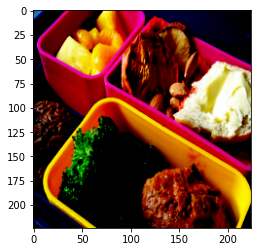

In [ ]:
print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in eval dataset (original validation set): {len(eval_dataset)}")
print(f"Number of samples in validation dataset: {len(val_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")
print("-"*20)
x, y, id = train_dataset[0]
print(f"Outputs of CocoDataset: ")
print(f"Image with a shape of: {x.shape}")
plt.imshow(x.permute(1,2,0))

print("Image captions: ")
for i in y:
    print(i)

## Example DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


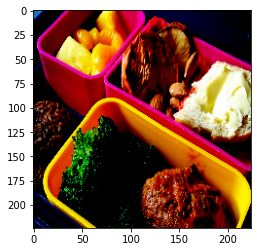

In [ ]:
train_loader_test = DataLoader(train_dataset, batch_size=3, shuffle=False, collate_fn = collate_custom, drop_last=True)

x, y, z, w  = next(iter(train_loader_test))
plt.imshow(x[0].squeeze().permute(1,2,0))

In [ ]:
z

[['Closeup of bins of food that include broccoli and bread.',
  'Colorful dishes holding meat, vegetables, fruit, and bread.',
  'there are containers filled with different kinds of foods',
  'A meal is presented in brightly colored plastic trays.',
  'A bunch of trays that have different food.'],
 ['A giraffe eating food from the top of the tree.',
  'A giraffe standing up nearby a tree ',
  'A giraffe mother with its baby in the forest.',
  'Two giraffes standing in a tree filled area.',
  'A giraffe standing next to a forest filled with trees.'],
 ['White vase with different colored flowers sitting inside of it. ',
  'a white vase with many flowers on a stage',
  'A flower vase is sitting on a porch stand.',
  'A vase with red and white flowers outside on a sunny day.',
  'A white vase filled with different colored flowers.'],
 ['Zebra reaching its head down to ground where grass is. ',
  'A zebra grazing on lush green grass in a field.',
  'The zebra is eating grass in the sun.',
 

In [ ]:
x.shape

torch.Size([14, 3, 224, 224])

In [ ]:
y

tensor([[  389,  4836,    28,     3,     9, 11734,    30,   420,    13,    34,
            16,     3,     9,  1228,     5,     1,     0,     0,     0,     0,
             0],
        [   71,  3711,  9980,    30,     3,     9,  3829,    28,     3,     9,
            21,   157,     5,     1,     0,     0,     0,     0,     0,     0,
             0],
        [  290,    19,     3,     9,  2815, 14372,    28,  7614,  3950,     1,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  128,  5956,    11,     3,     9,   568,    16,     3,     9,  1692,
          8677,  3214,     3,     9,  1782,    11,   387,     1,     0,     0,
             0],
        [   71,  2335,  3753,     3,     9,  6871,    28,     3,     9,    21,
           157,    11, 10821,     5,     1,     0,     0,     0,     0,     0,
             0],
        [   71,   887,   113,    19,  3753,   139,     3,     9,  4340,     5,
             1,     0,     0,     0,     0,   

In [ ]:
x

tensor([[[[-0.6557, -0.6201, -0.6160,  ..., -0.6386, -0.6641, -0.6683],
          [-0.6170, -0.6473, -0.6436,  ..., -0.6585, -0.6819, -0.6990],
          [-0.6395, -0.6569, -0.6771,  ..., -0.6564, -0.6633, -0.6661],
          ...,
          [-0.9911, -0.9919, -0.9914,  ..., -0.3324, -0.3658, -0.3944],
          [-0.9864, -0.9830, -0.9858,  ..., -0.3653, -0.3642, -0.3689],
          [-0.9887, -0.9801, -0.9788,  ..., -0.3741, -0.3947, -0.3601]],

         [[-0.7969, -0.7601, -0.7605,  ..., -0.5921, -0.5802, -0.6021],
          [-0.7582, -0.7918, -0.7859,  ..., -0.5978, -0.6046, -0.6367],
          [-0.7886, -0.8059, -0.8283,  ..., -0.5752, -0.5832, -0.5894],
          ...,
          [-0.9911, -0.9919, -0.9914,  ..., -0.4590, -0.4887, -0.5287],
          [-0.9864, -0.9830, -0.9858,  ..., -0.4882, -0.4784, -0.4944],
          [-0.9887, -0.9801, -0.9788,  ..., -0.4860, -0.5079, -0.4932]],

         [[-0.8988, -0.8983, -0.9096,  ..., -0.6193, -0.6258, -0.5971],
          [-0.8408, -0.9185, -

# Function to unormalize image (only for displaying results)

In [ ]:
# Function to unnormalize image only for displaying image without the normalization applied by transforms. 
# reference: <https://stackoverflow.com/questions/61368632/display-image-in-a-pil-format-from-torch-tensor>

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)